# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [2]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [3]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [4]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, hidden_dim1=H1, hidden_dim2=H2, dropout_p=DROPOUT_P):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim1),      # <-- hidden layer 1 (weights + bias)
            nn.BatchNorm1d(hidden_dim1),         # <-- batch norm (stability/regularization)
            nn.ReLU(),                           # <-- nonlinearity
            nn.Dropout(dropout_p),               # <-- dropout regularization

            nn.Linear(hidden_dim1, hidden_dim2), # <-- hidden layer 2
            nn.BatchNorm1d(hidden_dim2),         # <-- batch norm
            nn.ReLU(),                           # <-- nonlinearity
            nn.Dropout(dropout_p),               # <-- dropout regularization

            nn.Linear(hidden_dim2, OUT_DIM)      # <-- output (linear for regression, 4 outputs)
        )

    def forward(self, x):
        return self.net(x)



In [5]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model = DNN_Reg4(
    in_dim=X_train_s1.shape[1],
    hidden_dim1=H1,
    hidden_dim2=H2,
    dropout_p=DROPOUT_P
).to(device)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY   # <-- L2 regularization
)

model

DNN_Reg4(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [7]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            pred = model(xb)

            # compute loss
            loss = loss_fn(pred, yb)

            # backward
            loss.backward()

            # optimizer step
            optimizer.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            print(f"Epoch {ep:4d} | train MSE: {total / n:.6f}")

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

# TODO: Train the model
train_part1(model, train_loader_1, epochs=EPOCHS)

Epoch    1 | train MSE: 0.768150
Epoch  500 | train MSE: 0.101363
Epoch 1000 | train MSE: 0.101603


In [8]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.9226    0.7366    0.8192      2377
           C     1.0000    0.9169    0.9567      2263
           B     0.9675    0.9529    0.9601      3057
           A     0.9680    0.9711    0.9695      3144

   micro avg     0.9659    0.9032    0.9335     10841
   macro avg     0.9645    0.8944    0.9264     10841
weighted avg     0.9646    0.9032    0.9312     10841
 samples avg     0.6628    0.6386    0.6451     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2978  147]
 [ 626 1751]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 188 2075]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2347   98]
 [ 144 2913]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2257  101]
 [  91 3053]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.9132    0.7223    0.8066      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

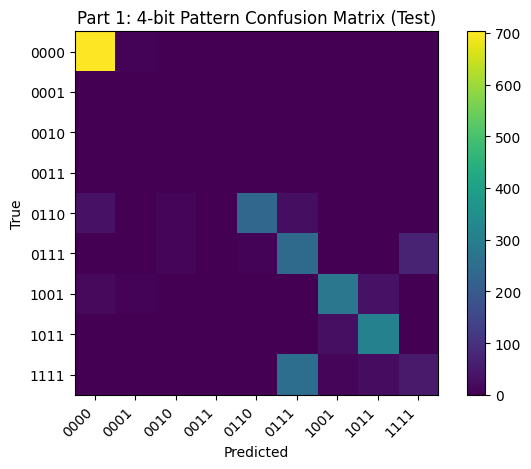

[[703   6   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 34   0   9   0 232  26   0   0   0]
 [  0   0   9   0   7 244   0   0  69]
 [ 17   8   0   0   0   0 280  34   0]
 [  1   0   1   1   0   0  28 309   0]
 [  0   0   0   0   2 253   9  24  52]]


In [9]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [10]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [11]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, hidden_dim1=H1, hidden_dim2=H2, dropout_p=DROPOUT_P):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim1),      # <-- hidden layer 1
            nn.BatchNorm1d(hidden_dim1),         # <-- batch norm
            nn.ReLU(),                           # <-- nonlinearity
            nn.Dropout(dropout_p),               # <-- dropout

            nn.Linear(hidden_dim1, hidden_dim2), # <-- hidden layer 2
            nn.BatchNorm1d(hidden_dim2),         # <-- batch norm
            nn.ReLU(),                           # <-- nonlinearity
            nn.Dropout(dropout_p),               # <-- dropout

            nn.Linear(hidden_dim2, OUT_DIM)      # <-- output logits (NO sigmoid here)
        )

    def forward(self, x):
        return self.net(x)  # (N,4) logits



In [12]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model_2 = DNN_MultiLabel4(
    in_dim=X_train_s2.shape[1],
    hidden_dim1=H1,
    hidden_dim2=H2,
    dropout_p=DROPOUT_P
).to(device)

loss_fn_2 = nn.BCEWithLogitsLoss()

optimizer_2 = torch.optim.Adam(
    model_2.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY   # <-- L2 regularization
)

model_2


DNN_MultiLabel4(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [13]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer_2.zero_grad()

            # forward pass (logits)
            logits = model(xb)

            # compute loss (BCE on logits)
            loss = loss_fn_2(logits, yb)

            # backward + step
            loss.backward()
            optimizer_2.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            print(f"Epoch {ep:4d} | train BCE (logits): {total / n:.6f}")

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# TODO: Train the model
train_part2(model_2, train_loader_2, epochs=EPOCHS)


Epoch    1 | train BCE (logits): 0.727443
Epoch  500 | train BCE (logits): 0.214528
Epoch 1000 | train BCE (logits): 0.209485


In [14]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.4320    1.0000    0.6034      2377
           C     0.4215    1.0000    0.5930      2263
           B     0.5556    1.0000    0.7143      3057
           A     0.5714    1.0000    0.7273      3144

   micro avg     0.4956    1.0000    0.6627     10841
   macro avg     0.4951    1.0000    0.6595     10841
weighted avg     0.5051    1.0000    0.6684     10841
 samples avg     0.4966    0.6992    0.5714     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[   0 3125]
 [   0 2377]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[ 133 3106]
 [   0 2263]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[   0 2445]
 [   0 3057]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[   0 2358]
 [   0 3144]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.4320    1.0000    0.6033      1019
           C     0.4216    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


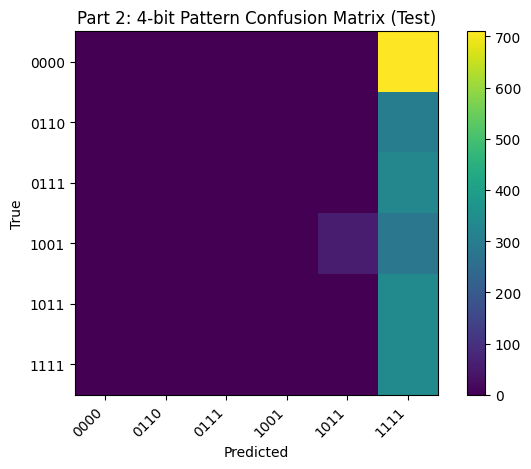

[[  0   0   0   0   0 710]
 [  0   0   0   0   0 301]
 [  0   0   0   0   0 329]
 [  0   0   0   0  58 281]
 [  0   0   0   0   0 340]
 [  0   0   0   0   0 340]]


In [15]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [16]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [17]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, hidden_dim1=H1, hidden_dim2=H2, num_classes=6, dropout_p=DROPOUT_P):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim1),        # <-- hidden layer 1
            nn.BatchNorm1d(hidden_dim1),           # <-- batch norm
            nn.ReLU(),                             # <-- nonlinearity
            nn.Dropout(dropout_p),                 # <-- dropout

            nn.Linear(hidden_dim1, hidden_dim2),   # <-- hidden layer 2
            nn.BatchNorm1d(hidden_dim2),           # <-- batch norm
            nn.ReLU(),                             # <-- nonlinearity
            nn.Dropout(dropout_p),                 # <-- dropout

            nn.Linear(hidden_dim2, num_classes)    # <-- output logits (NO softmax here)
        )

    def forward(self, x):
        return self.net(x)  # (N,6) logits


In [18]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model_3 = DNN_MultiClass6(
    in_dim=X_train_s3.shape[1],
    hidden_dim1=H1,
    hidden_dim2=H2,
    num_classes=6,
    dropout_p=DROPOUT_P
).to(device)

loss_fn_3 = nn.CrossEntropyLoss()

optimizer_3 = torch.optim.Adam(
    model_3.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY   # <-- L2 regularization
)

model_3

DNN_MultiClass6(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=8, out_features=6, bias=True)
  )
)

In [19]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer_3.zero_grad()

            # forward pass (logits)
            logits = model(xb)

            # compute loss (cross-entropy on logits)
            loss = loss_fn_3(logits, yb)

            # backward + step
            loss.backward()
            optimizer_3.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            print(f"Epoch {ep:4d} | train CE loss: {total / n:.6f}")

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part3(model_3, train_loader_3, epochs=EPOCHS)


Epoch    1 | train CE loss: 1.948554
Epoch  500 | train CE loss: 0.629862
Epoch 1000 | train CE loss: 0.585553



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.0000    0.0000    0.0000      1655
          LG     0.0000    0.0000    0.0000       790
          LL     0.2102    0.7354    0.3270       703
         LLG     0.4628    0.9861    0.6299       794
         LLL     0.0000    0.0000    0.0000       767
        LLLG     0.0000    0.0000    0.0000       793

    accuracy                         0.2363      5502
   macro avg     0.1122    0.2869    0.1595      5502
weighted avg     0.0936    0.2363    0.1327      5502



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


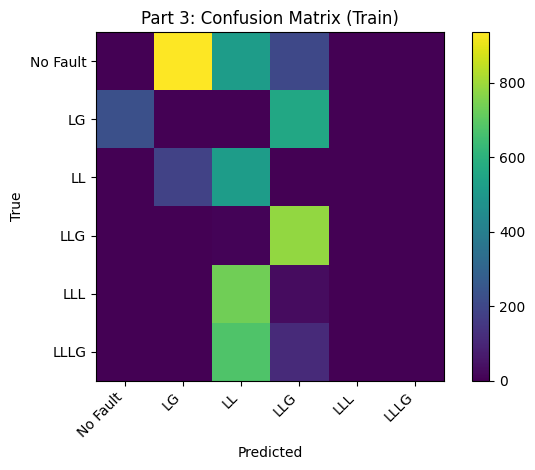


=== Part 3 | Test ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    No Fault     0.0000    0.0000    0.0000       710
          LG     0.0000    0.0000    0.0000       339
          LL     0.1949    0.6645    0.3014       301
         LLG     0.4694    0.9912    0.6371       340
         LLL     0.0000    0.0000    0.0000       329
        LLLG     0.0000    0.0000    0.0000       340

    accuracy                         0.2276      2359
   macro avg     0.1107    0.2759    0.1564      2359
weighted avg     0.0925    0.2276    0.1303      2359



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


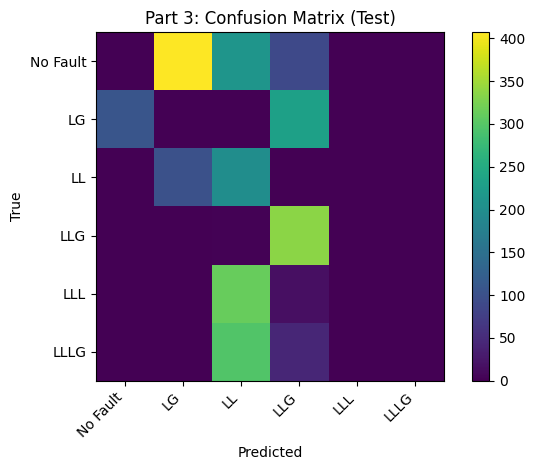

In [21]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- **Q1:**

The regression-style bit model (Part 1) fits this dataset best. It achieves very strong test F1-scores for all four bits (macro F1 is 0.92–0.97 range per bit) and maintains high precision and recall without collapsing to trivial predictions. In contrast, the multi-label model (Part 2) degenerated into predicting all 1’s (recall = 1.0, precision is 0.5), and the multi-class model (Part 3) achieved very low accuracy (~23%) and failed to learn most classes. This suggests the bit-wise formulation aligns better with the structure of the underlying fault representation.

- **Q2:**

Yes, both bit-based approaches can theoretically produce invalid 4-bit combinations because each bit is predicted independently. In Part 2 especially, the model predicted all bits as 1, which clearly does not correspond to a valid fault pattern in many cases. This suggests that treating the bits as fully independent ignores structural constraints between fault types, and without additional regularization or constraint enforcement, invalid combinations can occur.


- **Q3:**

Bit G was the hardest in Parts 1 and 2 (recall ~0.72 in test for Part 1), indicating more confusion or imbalance for ground-related faults. In Part 3, most classes except LLG and partially LL collapsed completely (zero precision/recall for No Fault, LG, LLL, LLLG). A plausible reason is class imbalance combined with strong feature similarity between certain fault types, causing the multi-class model to converge to predicting only a few dominant or easier-to-separate classes.



## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [23]:
# ----------------------------
# 1) Build binary labels: 0 = No Fault (0000), 1 = Fault (anything else)
# ----------------------------
y_bin = (Y_bits.sum(axis=1) > 0).astype(int)   # 1 if any bit is 1 else 0

# ----------------------------
# 2) 70/30 stratified split
# ----------------------------
X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X, y_bin,
    test_size=0.30,
    random_state=0,
    stratify=y_bin
)

# ----------------------------
# 3) Robust scaling (fit on train only)
# ----------------------------
scaler_5 = RobustScaler()
X_train_s5 = scaler_5.fit_transform(X_train5).astype(np.float32)
X_test_s5  = scaler_5.transform(X_test5).astype(np.float32)

# Torch tensors
Xtr5 = torch.from_numpy(X_train_s5)
Xte5 = torch.from_numpy(X_test_s5)

ytr5 = torch.from_numpy(y_train5.astype(np.float32)).view(-1, 1)
yte5 = torch.from_numpy(y_test5.astype(np.float32)).view(-1, 1)

BATCH_SIZE = 256
train_loader_5 = DataLoader(TensorDataset(Xtr5, ytr5), batch_size=BATCH_SIZE, shuffle=True)

# ----------------------------
# 4) Model: same style as class (Sequential), but output 1 logit
#    Architecture: 6 -> 16 -> 8 -> 1
# ----------------------------
class DNN_Binary(nn.Module):
    def __init__(self, in_dim=6, hidden_dim1=16, hidden_dim2=8, dropout_p=0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(hidden_dim2, 1)  # <-- logits for binary classification
        )

    def forward(self, x):
        return self.net(x)  # (N,1) logits

model_5 = DNN_Binary(
    in_dim=X_train_s5.shape[1],
    hidden_dim1=H1,
    hidden_dim2=H2,
    dropout_p=DROPOUT_P
).to(device)

loss_fn_5 = nn.BCEWithLogitsLoss()

optimizer_5 = torch.optim.Adam(
    model_5.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY
)

model_5


DNN_Binary(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [24]:
# ----------------------------
# 5) Train
# ----------------------------
def train_part5(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer_5.zero_grad()
            logits = model(xb)
            loss = loss_fn_5(logits, yb)
            loss.backward()
            optimizer_5.step()

            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            print(f"Epoch {ep:4d} | train BCE (logits): {total / n:.6f}")

@torch.no_grad()
def predict_part5(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy().ravel()
    y_pred = (probs >= threshold).astype(int)
    return y_pred

train_part5(model_5, train_loader_5, epochs=EPOCHS)


Epoch    1 | train BCE (logits): 0.651404
Epoch  500 | train BCE (logits): 0.081503
Epoch 1000 | train BCE (logits): 0.060144


=== Part 5 | Train ===
              precision    recall  f1-score   support

           0     0.9650    1.0000    0.9822      1655
           1     1.0000    0.9844    0.9921      3847

    accuracy                         0.9891      5502
   macro avg     0.9825    0.9922    0.9872      5502
weighted avg     0.9895    0.9891    0.9891      5502



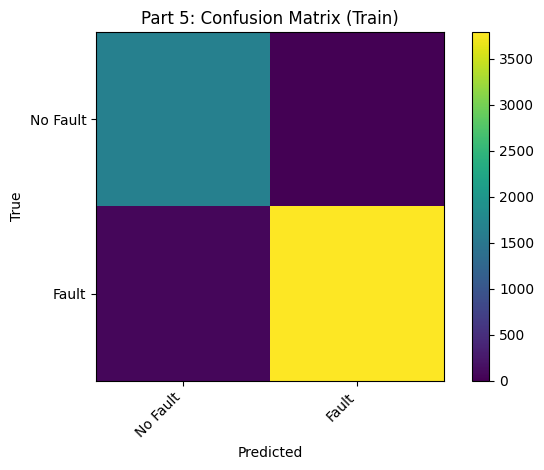

=== Part 5 | Test ===
              precision    recall  f1-score   support

           0     0.9556    1.0000    0.9773       710
           1     1.0000    0.9800    0.9899      1649

    accuracy                         0.9860      2359
   macro avg     0.9778    0.9900    0.9836      2359
weighted avg     0.9866    0.9860    0.9861      2359



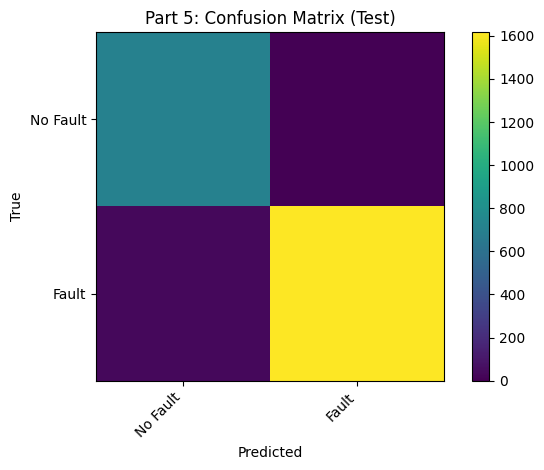

In [25]:
# ----------------------------
# 6) Evaluate on Train
# ----------------------------
yhat_train5 = predict_part5(model_5, X_train_s5)
cm_train5 = confusion_matrix(y_train5, yhat_train5)
print("=== Part 5 | Train ===")
print(classification_report(y_train5, yhat_train5, digits=4))
plot_cm(cm_train5, title="Part 5: Confusion Matrix (Train)", labels=["No Fault", "Fault"])

# ----------------------------
# 7) Evaluate on Test
# ----------------------------
yhat_test5 = predict_part5(model_5, X_test_s5)
cm_test5 = confusion_matrix(y_test5, yhat_test5)
print("=== Part 5 | Test ===")
print(classification_report(y_test5, yhat_test5, digits=4))
plot_cm(cm_test5, title="Part 5: Confusion Matrix (Test)", labels=["No Fault", "Fault"])
